## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- The models use a 7 day lookback window to produce series data for training and testing
- 2 optimizations were used and an overall R2 score of .90 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-11-05T00:00:00.0000000Z', 'time_period_end': '2023-11-06T00:00:00.0000000Z', 'time_open': '2023-11-05T00:00:40.0380000Z', 'time_close': '2023-11-05T23:26:44.7780000Z', 'price_open': 1857.9, 'price_high': 1913.3, 'price_low': 1848.6, 'price_close': 1900.6, 'volume_traded': 2590.00198092, 'trades_count': 4282}, {'time_period_start': '2023-11-04T00:00:00.0000000Z', 'time_period_end': '2023-11-05T00:00:00.0000000Z', 'time_open': '2023-11-04T00:00:33.2530000Z', 'time_close': '2023-11-04T23:59:44.6100000Z', 'price_open': 1833.9, 'price_high': 1869.6, 'price_low': 1825.3, 'price_close': 1857.2, 'volume_traded': 1265.86462663, 'trades_count': 3204}, {'time_period_start': '2023-11-03T00:00:00.0000000Z', 'time_period_end': '2023-11-04T00:00:00.0000000Z', 'time_open': '2023-11-03T00:00:08.0600000Z', 'time_close': '2023-11-03T23:59:23.7570000Z', 'price_open': 1801, 'price_high': 1835.3, 'price_low': 1778.8, 'price_close': 1832.6, 'volume_traded': 1633.19945308, 'trades

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-11-05T00:00:00.0000000Z,2023-11-06T00:00:00.0000000Z,2023-11-05T00:00:40.0380000Z,2023-11-05T23:26:44.7780000Z,1857.9,1913.3,1848.6,1900.6,2590.001981,4282
1,2023-11-04T00:00:00.0000000Z,2023-11-05T00:00:00.0000000Z,2023-11-04T00:00:33.2530000Z,2023-11-04T23:59:44.6100000Z,1833.9,1869.6,1825.3,1857.2,1265.864627,3204
2,2023-11-03T00:00:00.0000000Z,2023-11-04T00:00:00.0000000Z,2023-11-03T00:00:08.0600000Z,2023-11-03T23:59:23.7570000Z,1801.0,1835.3,1778.8,1832.6,1633.199453,4601
3,2023-11-02T00:00:00.0000000Z,2023-11-03T00:00:00.0000000Z,2023-11-02T00:00:22.9040000Z,2023-11-02T23:59:28.3260000Z,1848.2,1874.7,1785.9,1801.0,3208.544712,5121
4,2023-11-01T00:00:00.0000000Z,2023-11-02T00:00:00.0000000Z,2023-11-01T00:00:37.9120000Z,2023-11-01T23:59:26.5010000Z,1815.8,1858.9,1784.6,1847.4,5686.654426,6489


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


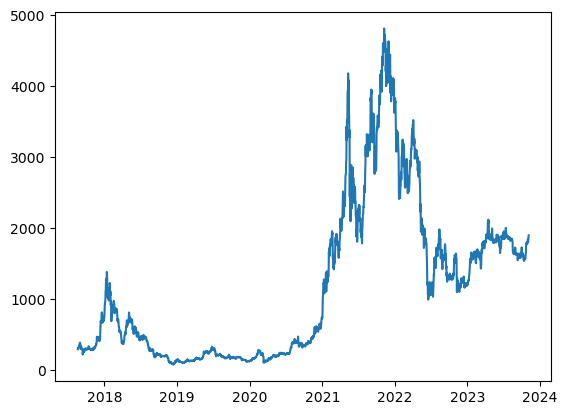

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features series
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2252, 7), (2252,), (2252,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1801, 7), (1801,), (225, 7), (225,), (226, 7), (226,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300


2023-11-05 18:27:21.721666: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


57/57 [==============================] - 1s 5ms/step - loss: 11.7768 - mean_absolute_error: 2.6360 - val_loss: 0.8687 - val_mean_absolute_error: 0.9226
Epoch 2/300
57/57 [==============================] - 0s 2ms/step - loss: 0.7179 - mean_absolute_error: 0.7322 - val_loss: 0.1713 - val_mean_absolute_error: 0.4072
Epoch 3/300
57/57 [==============================] - 0s 2ms/step - loss: 0.0375 - mean_absolute_error: 0.1283 - val_loss: 0.0041 - val_mean_absolute_error: 0.0467
Epoch 4/300
57/57 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0636 - val_loss: 0.0045 - val_mean_absolute_error: 0.0506
Epoch 5/300
57/57 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0607 - val_loss: 0.0115 - val_mean_absolute_error: 0.0935
Epoch 6/300
57/57 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0603 - val_loss: 0.0073 - val_mean_absolute_error: 0.0696
Epoch 7/300
57/57 [==============

35/35 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0531 - val_loss: 0.0217 - val_mean_absolute_error: 0.1177
Epoch 200/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_absolute_error: 0.0434 - val_loss: 0.0280 - val_mean_absolute_error: 0.1392
Epoch 201/300
35/35 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0400 - val_loss: 0.0272 - val_mean_absolute_error: 0.1393
Epoch 202/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0463 - val_loss: 0.0257 - val_mean_absolute_error: 0.1323
Epoch 203/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0391 - val_loss: 0.0244 - val_mean_absolute_error: 0.1303
Epoch 204/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0467 - val_loss: 0.0223 - val_mean_absolute_error: 0.1214
Epoch 205/300
35/3

35/35 [==============================] - 1s 24ms/step - loss: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 249/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0401 - val_loss: 0.0155 - val_mean_absolute_error: 0.1029
Epoch 250/300
35/35 [==============================] - 1s 26ms/step - loss: 0.0033 - mean_absolute_error: 0.0404 - val_loss: 0.0121 - val_mean_absolute_error: 0.0860
Epoch 251/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_absolute_error: 0.0409 - val_loss: 0.0319 - val_mean_absolute_error: 0.1578
Epoch 252/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_absolute_error: 0.0404 - val_loss: 0.0165 - val_mean_absolute_error: 0.1032
Epoch 253/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0035 - mean_absolute_error: 0.0418 - val_loss: 0.0085 - val_mean_absolute_error: 0.0715
Epoch 254/300
35/3

35/35 [==============================] - 0s 13ms/step - loss: 0.0039 - mean_absolute_error: 0.0457 - val_loss: 0.0232 - val_mean_absolute_error: 0.1308
Epoch 298/300
35/35 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0103 - val_mean_absolute_error: 0.0794
Epoch 299/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0553 - val_loss: 0.0083 - val_mean_absolute_error: 0.0706
Epoch 300/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0054 - mean_absolute_error: 0.0560 - val_loss: 0.0075 - val_mean_absolute_error: 0.0670


57/57 [==============================] - 0s 702us/step


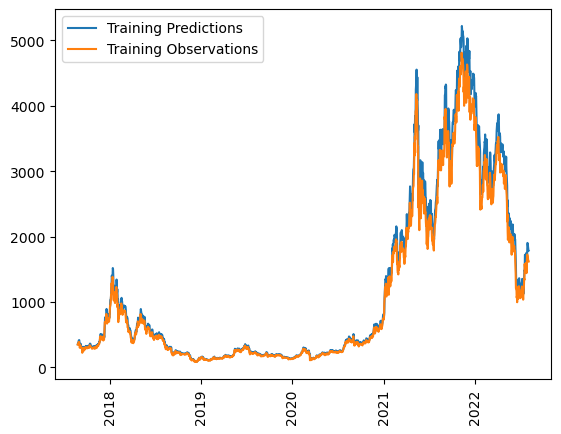

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00967350136488676
Val MAE: 0.09059799462556839


8/8 [==============================] - 0s 1ms/step


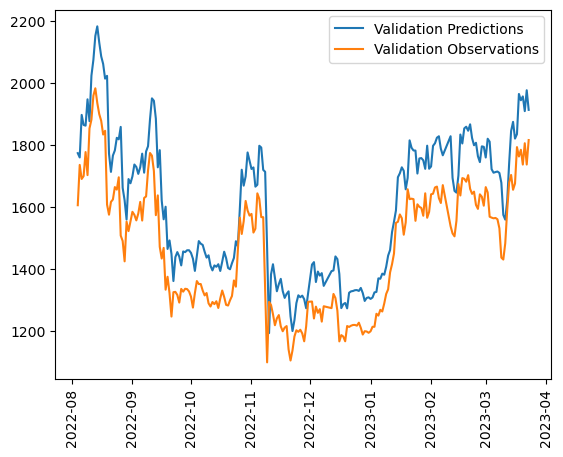

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0090339919552207
Test MAE: 0.09283770620822906


8/8 [==============================] - 0s 1ms/step


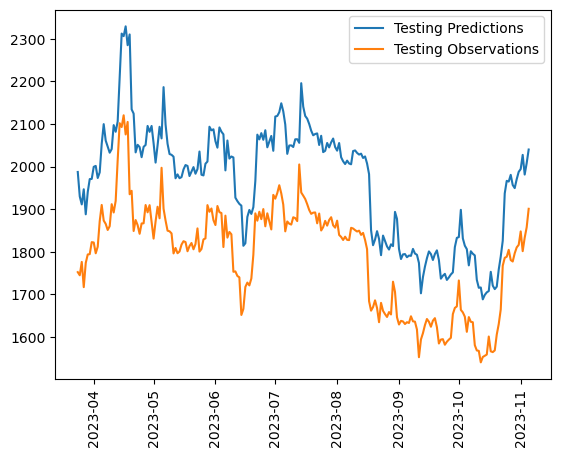

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  -0.8593358395910107


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((878,), (878, 7), (878,), (135,), (135, 7), (135,), (113,), (113, 7), (113,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
28/28 [==============================] - 1s 8ms/step - loss: 55.9592 - mean_absolute_error: 7.4550 - val_loss: 53.9384 - val_mean_absolute_error: 7.3440
Epoch 2/200
28/28 [==============================] - 0s 2ms/step - loss: 52.9652 - mean_absolute_error: 7.2524 - val_loss: 51.2043 - val_mean_absolute_error: 7.1554
Epoch 3/200
28/28 [==============================] - 0s 2ms/step - loss: 50.2291 - mean_absolute_error: 7.0612 - val_loss: 48.3698 - val_mean_absolute_error: 6.9545
Epoch 4/200
28/28 [==============================] - 0s 2ms/step - loss: 47.1379 - mean_absolute_error: 6.8392 - val_loss: 44.8059 - val_mean_absolute_error: 6.6934
Epoch 5/200
28/28 [==============================] - 0s 2ms/step - loss: 42.8960 - mean_absolute_error: 6.5210 - val_loss: 39.8394 - val_mean_absolute_error: 6.3115
Epoch 6/200
28/28 [==============================] - 0s 2ms/step - loss: 37.3970 - mean_absolute_error: 6.0845 - val_loss: 33.6908 - val_mean_absolute_error: 5.8040
Epoch 7/20

28/28 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_absolute_error: 0.0559 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 199/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_absolute_error: 0.0545 - val_loss: 0.0013 - val_mean_absolute_error: 0.0279
Epoch 200/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0053 - mean_absolute_error: 0.0546 - val_loss: 0.0012 - val_mean_absolute_error: 0.0260


28/28 [==============================] - 0s 659us/step


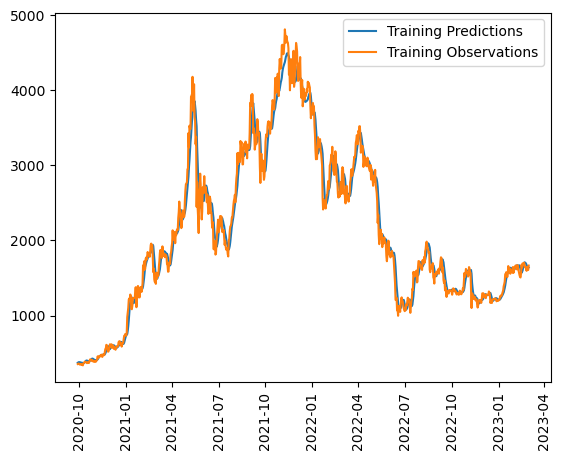

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00134503492154181
Val MAE: 0.027733566239476204


5/5 [==============================] - 0s 727us/step


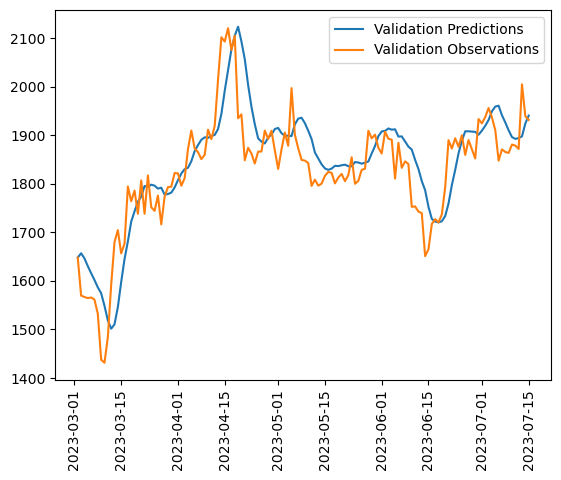

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0008441549143753946
Test MAE: 0.023026129230856895


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 975us/step
R2 Score:  0.8075238275475235


4/4 [==============================] - 0s 961us/step


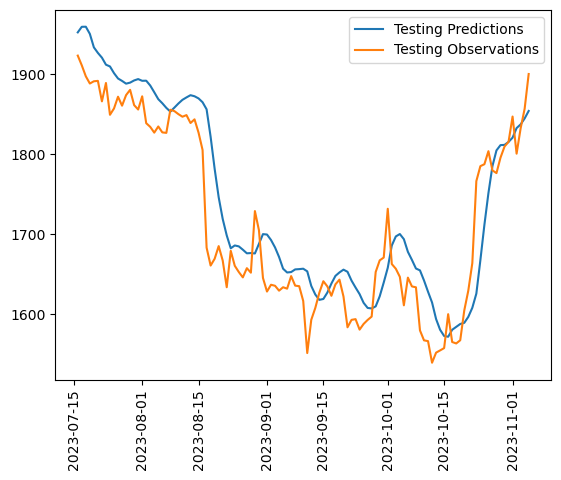

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 1s 8ms/step - loss: 24.4021 - mean_absolute_error: 4.3151 - val_loss: 4.0270 - val_mean_absolute_error: 2.0057
Epoch 2/300
28/28 [==============================] - 0s 2ms/step - loss: 1.0915 - mean_absolute_error: 0.8586 - val_loss: 0.2017 - val_mean_absolute_error: 0.4445
Epoch 3/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3493 - mean_absolute_error: 0.4617 - val_loss: 0.0194 - val_mean_absolute_error: 0.1247
Epoch 4/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3069 - mean_absolute_error: 0.4332 - val_loss: 0.0043 - val_mean_absolute_error: 0.0437
Epoch 5/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2835 - mean_absolute_error: 0.4189 - val_loss: 0.0072 - val_mean_absolute_error: 0.0668
Epoch 6/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2348 - mean_absolute_error: 0.3819 - val_loss: 0.0203 - val_mean_absolute_error: 0.1318
Epoch 7/300
28/28 [==

28/28 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_absolute_error: 0.0437 - val_loss: 8.0573e-04 - val_mean_absolute_error: 0.0216
Epoch 198/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 6.3997e-04 - val_mean_absolute_error: 0.0183
Epoch 199/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0069 - val_mean_absolute_error: 0.0790
Epoch 200/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0444 - val_loss: 0.0014 - val_mean_absolute_error: 0.0326
Epoch 201/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0081 - val_mean_absolute_error: 0.0862
Epoch 202/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_absolute_error: 0.0580 - val_loss: 0.0034 - val_mean_absolute_error: 0.0532
Epoch 203/

28/28 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0451 - val_loss: 0.0010 - val_mean_absolute_error: 0.0253
Epoch 247/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0439 - val_loss: 0.0014 - val_mean_absolute_error: 0.0311
Epoch 248/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0032 - val_mean_absolute_error: 0.0519
Epoch 249/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0447 - val_loss: 0.0010 - val_mean_absolute_error: 0.0259
Epoch 250/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 8.9192e-04 - val_mean_absolute_error: 0.0233
Epoch 251/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0029 - val_mean_absolute_error: 0.0486
Epoch 252/300


28/28 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 8.3611e-04 - val_mean_absolute_error: 0.0232
Epoch 296/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 7.8492e-04 - val_mean_absolute_error: 0.0221
Epoch 297/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_absolute_error: 0.0447 - val_loss: 0.0023 - val_mean_absolute_error: 0.0422
Epoch 298/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_absolute_error: 0.0450 - val_loss: 0.0097 - val_mean_absolute_error: 0.0954
Epoch 299/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0038 - val_mean_absolute_error: 0.0566
Epoch 300/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0428 - val_loss: 0.0013 - val_mean_absolute_error: 0.0302


28/28 [==============================] - 0s 672us/step


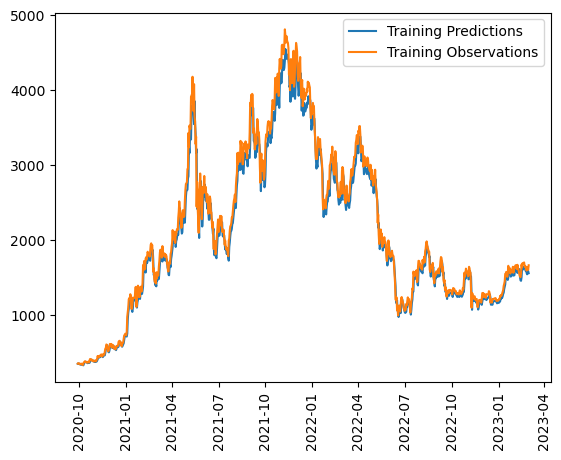

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0017510957550257444
Val MAE: 0.03581324964761734


5/5 [==============================] - 0s 739us/step


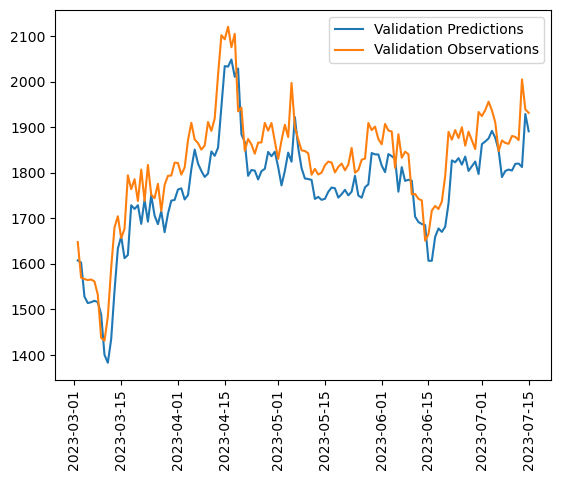

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0012576720910146832
Test MAE: 0.032448675483465195


4/4 [==============================] - 0s 816us/step


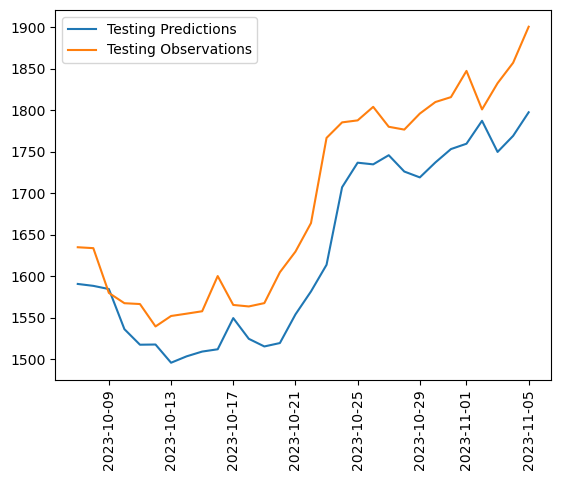

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.7132377758319675


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the best scoring model for testing predictions

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7
#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))

#Adding future dates at the end of the dateset   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 8ms/step
[7.4941897, 7.4909368, 7.4912157, 7.4919114, 7.4921055, 7.4921002, 7.4919777]
2023-11-06
2023-11-07
2023-11-08
2023-11-09
2023-11-10
2023-11-11
2023-11-12


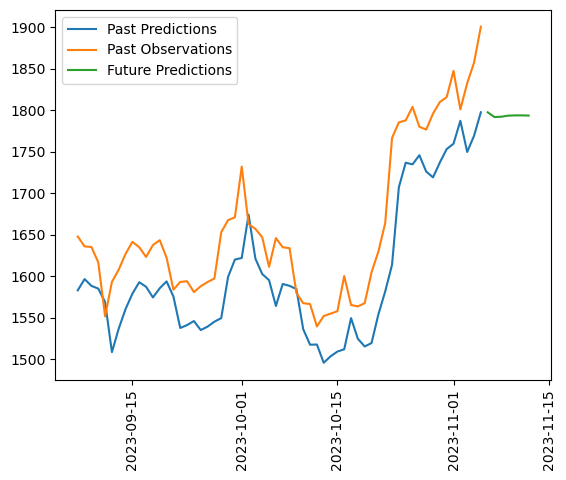

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-08-08,1855.9,2005.223633,1853.596802,1768.975952
2023-08-09,1854.2,2036.341919,1858.584106,1794.616333
2023-08-10,1850.4,2037.812622,1863.739380,1797.578857
2023-08-11,1847.2,2031.959717,1868.301392,1792.353516
2023-08-12,1849.2,2028.060669,1871.328369,1788.274536
...,...,...,...,...
2023-11-01,1847.4,1994.040039,1821.016602,1759.676270
2023-11-02,1801.0,2027.317139,1832.986572,1787.289185
2023-11-03,1832.6,1981.095825,1837.590698,1749.795410


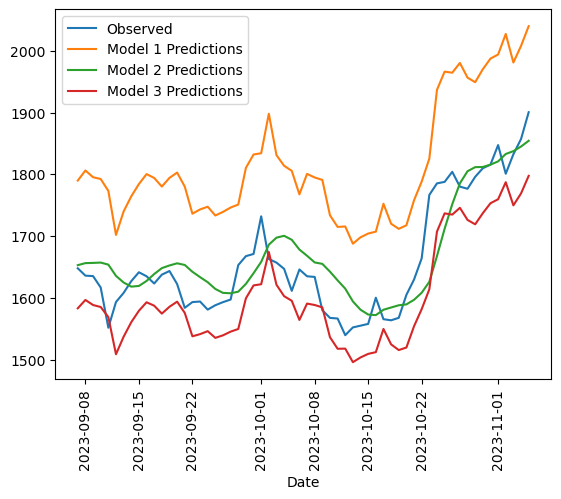

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  -0.8593358395910107
Model 2 R2 Score:  0.8075238275475235
Model 3 R2 Score:  0.7132377758319675
